In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda as cuda

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

/home/jasper/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
torch.manual_seed(77)

In [4]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()



In [5]:
standardizer = transforms.Compose([transforms.Resize((32)), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [6]:
noise_dim = 100
conditional_dim = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 200
N_CRITIC = 5
W_CLIP = 0.01

In [7]:
train_data = datasets.MNIST(root='../mnist/', train=True, download=True, transform=standardizer)
test_data = datasets.MNIST(root='../mnist/', train=False, download=True, transform=standardizer)
total_train = torch.utils.data.ConcatDataset([train_data, test_data])

train_dataloader = torch.utils.data.DataLoader(dataset=total_train, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc1 = nn.Linear(11, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 1)
    
    def forward(self, x, labels):
        x = self.model(x)
        x = x.view((-1, 1))
        xs = torch.cat((x, labels), dim=1)
        xs = xs.view((-1, 11))
        xs = self.fc1(xs)
        xs = torch.relu(xs)
        xs = self.fc2(xs)
        xs = torch.relu(xs)
        xs = self.fc3(xs)
        xs = torch.relu(xs)
        xs = self.fc4(xs)
        xs = torch.relu(xs)
        return xs

In [9]:
disc = Discriminator().to(device)
#summary(disc, [(1, 32, 32), (1,)])

In [10]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.dconv = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + conditional_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        z_concat = torch.cat((x, labels), dim=1)
        z_concat = z_concat.view((-1, noise_dim + conditional_dim, 1, 1))
        imgs = self.dconv(z_concat)
        return imgs


In [11]:
gen = Generator().to(device)
#summary(gen, (132,))

In [12]:
def get_z(batch_size=BATCH_SIZE):
    z = cuda.FloatTensor(torch.randn(batch_size, noise_dim, device=device))
    return z

In [13]:
def train(G, D, optim_G, optim_D, train_loader):
    G.train()
    D.train()
    criterion = nn.BCELoss()
    for epoch in tqdm(range(EPOCHS)):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optim_G.zero_grad()

            labels = F.one_hot(labels, num_classes=10)
            labels = labels.view((-1, 10))

            z = get_z(batch_size=imgs.shape[0])

            optim_D.zero_grad()

            p_real = D(imgs, labels)
            p_fake = D(G(z, labels), labels)

            loss_d_real = criterion(p_real, torch.ones_like(p_real).to(device))
            loss_d_fake = criterion(p_fake, torch.zeros_like(p_fake).to(device))

            loss_d = (loss_d_real + loss_d_fake)

            loss_d.backward()
            optim_D.step()

            optim_G.zero_grad()

            loss_g = criterion(D(G(z, labels), labels), torch.ones_like(p_fake).to(device))
            
            loss_g.backward()
            optim_G.step()


        if epoch % 10 == 0:
            print(f'[{epoch}/{EPOCHS}] loss_d : {loss_d:.4f}, loss_g : {loss_g:.4f}')
            with torch.no_grad():
                lbls = torch.randint(0, 9, (16, 1))
                lbls = F.one_hot(lbls, num_classes=10)
                lbls = lbls.type(cuda.FloatTensor)
                lbls = lbls.view((16, -1))
                imshow_grid(G(get_z(batch_size=16), lbls))

    torch.save(G, './models/cGAN_Generator.pth')
    torch.save(D, './models/cGAN_Discriminator.pth')


In [14]:
optim_G = optim.Adam(gen.parameters(), lr=LEARNING_RATE)
optim_D = optim.Adam(gen.parameters(), lr=LEARNING_RATE)

  0%|          | 0/200 [00:00<?, ?it/s]

[0/200] loss_d : 3.6732, loss_g : 80.3552


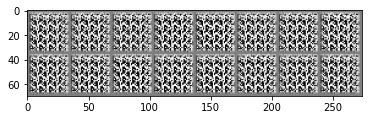

  5%|▌         | 10/200 [01:41<31:47, 10.04s/it]

[10/200] loss_d : 3.6473, loss_g : 91.4498


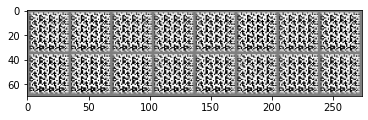

  8%|▊         | 15/200 [02:40<32:54, 10.67s/it]


KeyboardInterrupt: 

In [15]:
train(gen, disc, optim_G, optim_D, train_dataloader)